In [1]:
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report,precision_recall_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from collections import Counter
import itertools
import operator
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_normalized_strings(x):
    doc = nlp(x, disable=["parser", "ner"])
    lemma = [token.lemma_ for token in doc]
    text = [lemma_i for lemma_i in lemma if (lemma_i not in STOP_WORDS and 
                                             not lemma_i.isdigit() and 
                                             lemma_i.isalnum() and 
                                             len(lemma_i)> 1)]
    text = " ".join(text)
    return text 

In [3]:
train_data = pd.read_csv("data_v2/train_data.csv", usecols=["reviewText", "sentiment"])
val_data = pd.read_csv("data_v2/validation_data.csv", usecols=["reviewText", "sentiment"])
train_data = pd.concat([train_data, val_data], ignore_index=True)
train_data.dropna(inplace=True)

train_data["text"] = train_data["reviewText"].apply(lambda x: get_normalized_strings(x.lower().strip()))
train_data = train_data.sample(frac=1)

In [4]:
test_data = pd.read_csv("data_v2/test_data.csv", usecols=["reviewText", "sentiment"])

test_data.dropna(inplace=True)

test_data["text"] = test_data["reviewText"].apply(lambda x: get_normalized_strings(x.lower().strip()))


In [5]:
train_X = train_data["text"].to_list()
train_y = train_data["sentiment"].values

test_X = test_data["text"].to_list()
test_y = test_data["sentiment"].values

In [6]:
all_words = [x.split() for x in train_X]
all_words = list(itertools.chain.from_iterable(all_words))
word_distribution = Counter(all_words)
word_distribution = dict(sorted(word_distribution.items(), key=operator.itemgetter(1), reverse=True))

In [7]:
word_distribution

{'card': 4377,
 'work': 2251,
 'use': 1742,
 'phone': 1526,
 'gb': 1400,
 'great': 1196,
 'buy': 1135,
 'memory': 1092,
 'sandisk': 1065,
 'fast': 953,
 'sd': 932,
 'good': 858,
 'galaxy': 815,
 'price': 771,
 'speed': 712,
 'samsung': 671,
 'problem': 666,
 'storage': 610,
 'tablet': 594,
 'need': 594,
 'video': 590,
 'product': 574,
 'format': 521,
 'camera': 516,
 'music': 511,
 'issue': 491,
 'device': 483,
 'class': 474,
 'micro': 455,
 'purchase': 442,
 'read': 429,
 'like': 421,
 'transfer': 416,
 'recommend': 415,
 'time': 412,
 'file': 412,
 'write': 397,
 'adapter': 396,
 'note': 395,
 'space': 386,
 'come': 373,
 'new': 359,
 'picture': 343,
 'lot': 333,
 'store': 316,
 'amazon': 316,
 'far': 315,
 'datum': 295,
 'microsd': 290,
 'fine': 281,
 'gopro': 275,
 'month': 271,
 'brand': 271,
 'movie': 265,
 'want': 260,
 's3': 254,
 'computer': 247,
 'try': 245,
 'photo': 242,
 's4': 229,
 'think': 227,
 'capacity': 218,
 'know': 218,
 'perfectly': 216,
 'android': 214,
 'recogni

In [8]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,
                      max_features=2500, lowercase=True, 
                      stop_words='english', 
                      preprocessor=None
                      )

countvectorizer = CountVectorizer(max_df=0.90, min_df=2,
                                  max_features=2500, lowercase=True, 
                                  stop_words='english', 
                                  preprocessor=None)

In [9]:
%%time

train_tfidf=tfidf.fit_transform(train_X)
train_cvec=countvectorizer.fit_transform(train_X)


CPU times: user 82.5 ms, sys: 2.61 ms, total: 85.1 ms
Wall time: 84.1 ms


In [10]:
test_tfidf=tfidf.transform(test_X)
test_cvec=countvectorizer.transform(test_X)

In [11]:
def f1_score_manual(y, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for actual_value, predicted_value in zip(y, y_pred):
        if predicted_value == actual_value:  # t?
            if predicted_value:  # tp
                tp += 1
            else:  # tn
                tn += 1
        else:  # f?
            if predicted_value:  # fp
                fp += 1
            else:  # fn
                fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    print('----------------------------------')
    print('                 Actual Value')
    print('----------------------------------')
    print(f'            Positive    Negative')
    print(f'Positive    {tp:^8}    {fp:^8}')
    print(f'Negative    {fn:^8}    {tn:^8}')
    print('----------------------------------')
    return f1


In [12]:
def get_best_threshold_by_f1(y_true, y_pred, thresholds):
    best_score = -1
    best_threshold=-1
    
    for th in thresholds:
        y_pred_label = [int(yi>=th) for yi in y_pred]
        score = f1_score(y_true, y_pred_label, average="macro")
        if score > best_score:
            best_score = score
            best_threshold = th
    
    return best_threshold, best_score
    

In [13]:
lr_model = LogisticRegression(max_iter=1000, random_state=0)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

grid_search = GridSearchCV(estimator=lr_model, param_grid=grid,
                           n_jobs=-1, cv=5,
                           scoring='f1', refit=True,
                           verbose=3)

grid_result = grid_search.fit(train_tfidf, train_y)

print("Optimal set of Parameters: {}".format(grid_result.best_params_))

lr_model = LogisticRegression(max_iter=1000, random_state=0, **grid_result.best_params_)
lr_model.fit(train_tfidf, train_y)
train_proba_lr = lr_model.predict_proba(train_tfidf)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Optimal set of Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [14]:
train_proba_lr = train_proba_lr[:,1]
precision, recall, thresholds = precision_recall_curve(train_y, train_proba_lr)
best_threshold_lr, best_score_lr = get_best_threshold_by_f1(train_y, train_proba_lr, thresholds)

In [15]:
test_proba_lr = lr_model.predict_proba(test_tfidf)
test_proba_lr = test_proba_lr[:,1]
test_predict_labels_lr = [int(x>=best_threshold_lr) for x in test_proba_lr]


f1_score_manual(test_y, test_predict_labels_lr)
print(classification_report(test_y, test_predict_labels_lr))



----------------------------------
                 Actual Value
----------------------------------
            Positive    Negative
Positive      381          17   
Negative       12          29   
----------------------------------
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        46
           1       0.96      0.97      0.96       393

    accuracy                           0.93       439
   macro avg       0.83      0.80      0.82       439
weighted avg       0.93      0.93      0.93       439



In [19]:
dt_model = DecisionTreeClassifier(random_state=0)
criterion = ['gini', 'entropy']
max_depth = list(range(2,21,2))
max_features = ["sqrt", "log2"]

# define grid search
grid = dict(criterion=criterion, max_depth=max_depth, max_features=max_features)

grid_search = GridSearchCV(estimator=dt_model, param_grid=grid,
                           n_jobs=-1, cv=5,
                           scoring='f1', refit=True,
                           verbose=3)

grid_result = grid_search.fit(train_cvec, train_y)

print("Optimal set of Parameters: {}".format(grid_result.best_params_))

dt_model = DecisionTreeClassifier(random_state=0, **grid_result.best_params_)
dt_model.fit(train_cvec, train_y)
train_proba_dt = dt_model.predict_proba(train_cvec)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Optimal set of Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}


In [20]:
train_proba_dt = train_proba_dt[:,1]
precision, recall, thresholds = precision_recall_curve(train_y, train_proba_dt)
best_threshold_dt, best_score_dt = get_best_threshold_by_f1(train_y, train_proba_dt, thresholds)

In [21]:
test_proba_dt = dt_model.predict_proba(test_cvec)
test_proba_dt = test_proba_dt[:,1]
test_predict_labels_dt = [int(x>=best_threshold_dt) for x in test_proba_dt]


f1_score_manual(test_y, test_predict_labels_dt)
print(classification_report(test_y, test_predict_labels_dt))



----------------------------------
                 Actual Value
----------------------------------
            Positive    Negative
Positive      374          23   
Negative       19          23   
----------------------------------
              precision    recall  f1-score   support

           0       0.55      0.50      0.52        46
           1       0.94      0.95      0.95       393

    accuracy                           0.90       439
   macro avg       0.74      0.73      0.73       439
weighted avg       0.90      0.90      0.90       439



In [39]:
xg_model = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=0, error_score='raise')

max_depth= [2, 3, 4, 5, 6, 7, 8, 9]
n_estimators= [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
learning_rate= [0.1, 0.01, 0.05]


# define grid search
grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)

grid_search = GridSearchCV(estimator=xg_model, param_grid=grid,
                           n_jobs=-1, cv=5,
                           scoring='f1', refit=True,
                           verbose=True)

grid_result = grid_search.fit(train_tfidf, train_y)

print("Optimal set of Parameters: {}".format(grid_result.best_params_))

xg_model = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=0, **grid_result.best_params_)
xg_model.fit(train_tfidf, train_y)
train_proba_xg = xg_model.predict_proba(train_tfidf)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[03:52:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "error_score" } are not used.

Optimal set of Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180}


In [40]:
train_proba_xg = train_proba_xg[:,1]
precision, recall, thresholds = precision_recall_curve(train_y, train_proba_xg)
best_threshold_xg, best_score_xg = get_best_threshold_by_f1(train_y, train_proba_xg, thresholds)

In [41]:
test_proba_xg = xg_model.predict_proba(test_tfidf)
test_proba_xg = test_proba_xg[:,1]
test_predict_labels_xg = [int(x>=best_threshold_xg) for x in test_proba_xg]


f1_score_manual(test_y, test_predict_labels_xg)
print(classification_report(test_y, test_predict_labels_xg))



----------------------------------
                 Actual Value
----------------------------------
            Positive    Negative
Positive      381          15   
Negative       12          31   
----------------------------------
              precision    recall  f1-score   support

           0       0.72      0.67      0.70        46
           1       0.96      0.97      0.97       393

    accuracy                           0.94       439
   macro avg       0.84      0.82      0.83       439
weighted avg       0.94      0.94      0.94       439



In [42]:
best_threshold_xg

0.7162392

In [60]:
features_importances = xg_model.feature_importances_
features_importances_indicies = np.argsort(features_importances)

feature_names = tfidf.get_feature_names_out()

top50_fetures = [feature_names[features_importances_indicies[i]] for i in range(-1, -51, -1)][::-1]
top50_feature_importances = [features_importances[features_importances_indicies[i]] for i in range(-1, -51, -1)][::-1]

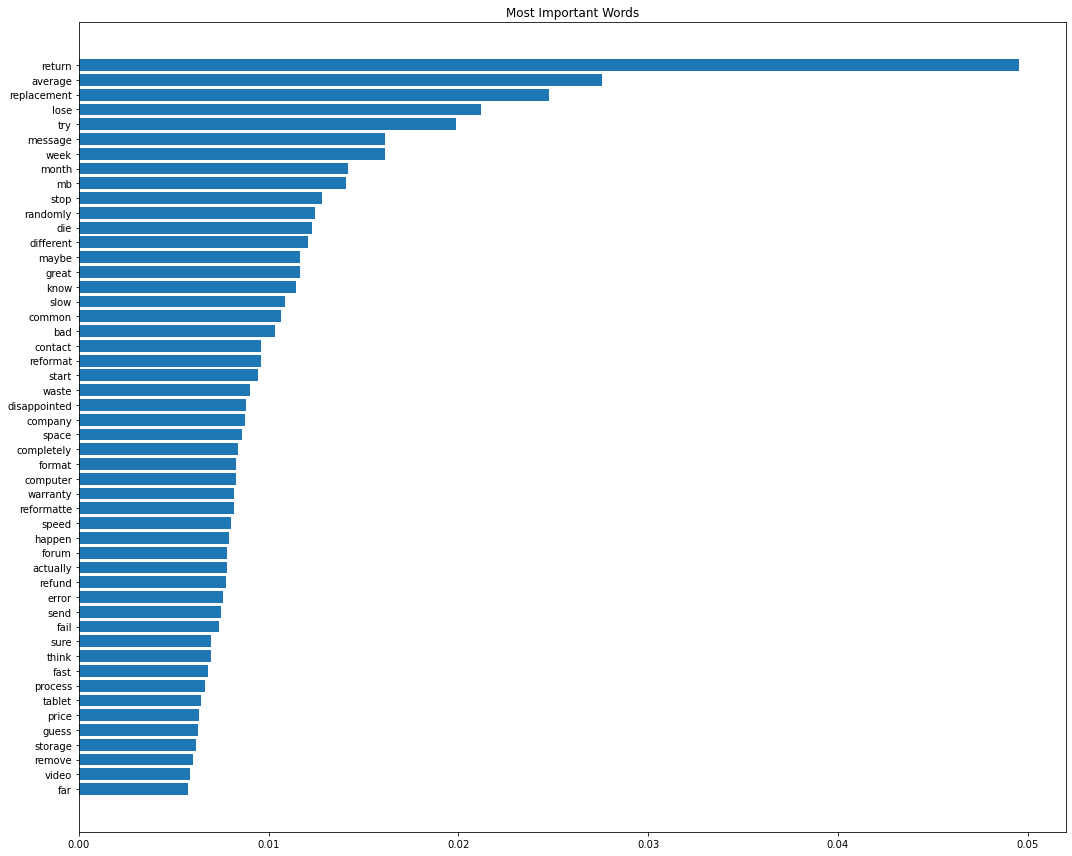

In [66]:
plt.figure(figsize=(15, 12))

plt.barh(top50_fetures, top50_feature_importances)
plt.title("Most Important Words")
plt.tight_layout()
plt.show()